Goal <br>
The goal of this project is to profile people in the above dataset based on available demographic attributes, and tell a story to non-technical audience on your findings. <br>
Example questions to guide your exploration include: <br>
1)	What are the key factors contributing to high vs. low income? <br>
2)	Are there any significant gaps in these Census attributes by gender or race? <br>
3)	Who are most likely to be successful investors? <br>
You are welcome to explore beyond these questions, if you discover anything else that might interest you along the way.

In [3]:
#Importing libraries
import pandas as pd
import io
import requests
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [1]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
content =requests.get(url).content
columns = ["age", "workingclass", "fnlwgt", "education", "education-num", "marital-status", "occupation" , "relationship", "race", "sex", "captial-gain", "capital-loss", "hours-per-week", "native-country", "income"] 
adult_df=pd.read_csv(io.StringIO(content.decode('utf-8')), header = None)

In [2]:
adult_df.columns = columns
adult_df.head()

,age,workingclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Exploratory data analysis

## Dataset information from UCI

UCI has given information about the data and features. We need to understand it thoroughly before we do any analysis.

The data is extracted from 1994 Census database using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) <br>
Following are the attributes and their types: <br>
&emsp;1) **age:** continuous <br>
&emsp;2) **workclass:** categorical  <br>
&emsp;3) **fnlwgt:** continuous, represents the number of units the record represents in the population. Unclear of it's usage <br>
&emsp;4) **education:** categorical <br>
&emsp;5) **education-num:** continuous<br>
&emsp;6) **marital-status:** categorical <br>
&emsp;7) **occupation:** categorical <br>
&emsp;8) **relationship:** categorical. Values - Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. Unclear of it's usage as a person might have multiple relationships <br>
&emsp;9) **race:** categorical<br>
&emsp;10) **sex:** categorical<br>
&emsp;11) **capital-gain:** continuous <br>
&emsp;12) **capital-loss:** continuous <br>
&emsp;13) **hours-per-week:** continuous, number of work the person has worked for in a week<br>
&emsp;14) **native-country:** categorical <br>
&emsp;15) **income:** categorical, class (not attribute) <=50K and >50K

## Further analysis

In [6]:
#Attribute statistics 
adult_df.shape

(32561, 15)

We have 32,561 records and 14 attributes. Last column is the income class

In [28]:
#Check for null values in all the columns
adult_df.isna().sum()

age               0
workingclass      0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
captial-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

We have no null values in out dataset

In [16]:
#Describe each continuous variable
adult_df.describe()

,age,education-num,captial-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


**Observations:** <br>
1) Age of all the individauls is **>17** <br>
2) age, education-num and hours-per-week **seem approx. normal distributions**. We can further check the distributions to confirm <br>
3) More than 75% of the data in capital-gain and capital-loss column is 0 as we see with **3rd Quartile (75%) = 0** <br>
4) **fnlwgt can be dropped** as we're unclear of it's usage 

In [17]:
#Describe each categorical variable
adult_df.describe(include = ["O"])

,workingclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


**Observations:** <br> 
Most (~70% +) of the data consists of people of **workingclass = Private, Race = White, Native country = US, incomce <=50K**

In [14]:
# dropping fnlwgt
adult_df.drop("fnlwgt", axis = 1, inplace = True)

1) age

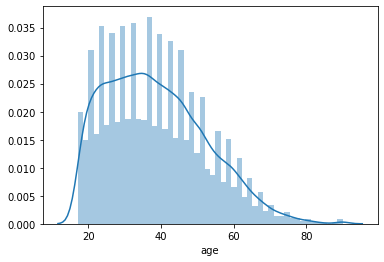

In [4]:
sns.distplot(adult_df["age"])